**LDA - Латентное размещение Дирихле**

**LDA** принадлежит семейству порождающих вероятностных моделей, в которых темы представлены вероятностями появления каждого слова из заданного набора. Документы в свою очередь могут быть представлены как сочетания тем. Уникальная особенность моделей LDA состоит в том что темы не обязательно должны быть различными и слова могут встречаться в нескольких темах; это придает некоторую нечеткость определяемым темам, что может пригодиться для совладения с гибкостью языка. 

В LDA каждый документ может рассматриваться как набор различных тематик. Подобный подход схож с вероятностным латентно-семантическим анализом (pLSA) с той разницей, что в LDA предполагается, что распределение тематик имеет в качестве априори распределения Дирихле. 



**Постановка задачи**

Построить модель набора тематик из текстов научно-исследовательских работ с конференции NeurIPS (Конференция по машинному обучению и нейровычислениям).


**Описание структуры исходных данных**

Исходные данные представляют собой тексты рукописных научно-исследовательских работ участников конференции, переведенные в цифровой формат с помощью технологии OCR $-$ оптического распознавания символов. Из-за этого в данных могут быть ошибки в словах и пропущенные буквы, что затрудняет задачу построения модели.


**Описание используемых функций и их параметров**

normalize_corpus() - функция предварительной обработки данных.
> - papers - исходные данные для обработки

gensim.models.Phrases() - автоматически находит общие фразы из потока предложений.
> - norm_papers - обработанные данные
> - min_count - минимальное необходимое количество фраз для темы
> - threshold - порог длины фразы
> - delimiter=b'_'- разделитель _ между фразой, состоящей из нескольких слов


gensim.models.LdaModel() - строит модель Латентного размещения Дирихле.
> - corpus - поток векторов документов (данных) 
> - id2word - отображение ID-слов к словам
> - chunksize - количество документов 
> - alpha - скаляр размещения Дирихле 
> - eta - скаляр размещения Дирихле 
> - random_state - значение случаной последовательности
> - iterations - количество итераций
> - num_topics - количество запрашиваемых латентных тематик
> - passes - количество прохождений по потоку во время тренировки модели

gensim.models.wrappers.LdaMallet() - строит модель Латентного размещения Дирихле с использованием фреймворка MALLET.
> - mallet_path - путь к MALLET
> - corpus - поток векторов документов (данных) 
> - num_topics  - количество запрашиваемых латентных тематик 
> - id2word - отображение ID-слов к словам
> - iterations - количество итераций
> - workers - количество потоков для работы

topic_model_coherence_generator() - генератор связности модели.
> - corpus - поток векторов документов (данных)  
> - texts - тесты документов
> - dictionary - словарь
> - start_topic_count - номер начала количества тематик 
> - end_topic_count - номер конца количества тематик  
> - step - шаг
> - cpus - количество используемых CPU

**Решение задачи**

Скачиваем исходные данные и подключаем библиотеки для работы.

In [ ]:
!wget https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
!tar -xzf nips12raw_str602.tgz

--2022-05-31 04:27:47--  https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12851423 (12M) [application/x-gzip]
Saving to: ‘nips12raw_str602.tgz’

nips12raw_str602.tg 100%[===================>]  12.26M  18.9MB/s    in 0.6s    

2022-05-31 04:27:47 (18.9 MB/s) - ‘nips12raw_str602.tgz’ saved [12851423/12851423]



In [ ]:
!pip install tqdm
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import os
import numpy as np
import pandas as pd

DATA_PATH = 'nipstxt/'

Загружаем данные в список.

In [ ]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
papers = []
for folder in folders:
    file_names = os.listdir(DATA_PATH + folder)
    for file_name in file_names:
        with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
            data = f.read()
        papers.append(data)

Выполним предварительную обработку данных.

In [ ]:
%%time
import nltk
import tqdm
#Выставляем стоп-слова для Английского языка
stop_words = nltk.corpus.stopwords.words('english')
#Разделяем строку на подстроки
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

def normalize_corpus(papers):
    norm_papers = []
    for paper in tqdm.tqdm(papers):
      #Переводим данные в нижний регистр и разделяем на токены (отдельные слова)
        paper = paper.lower()
        paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
        paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
        paper_tokens = [token for token in paper_tokens if len(token) > 1]
        paper_tokens = [token for token in paper_tokens if token not in stop_words]
        paper_tokens = list(filter(None, paper_tokens))
        if paper_tokens:
            norm_papers.append(paper_tokens)
            
    return norm_papers
    
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

100%|██████████| 1740/1740 [00:38<00:00, 45.46it/s]

1740
CPU times: user 36.5 s, sys: 476 ms, total: 37 s
Wall time: 38.3 s


Построим фразовую биграмму на исходных данных, чтобы удалить ненужные термины. Начнем с доставания и генерации слов и биграмм в качестве фраз для каждой разбитой на токены научно-исследовательской работы.


In [ ]:
import gensim

bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_') #Чем больше порог, тем меньше фраз мы получим.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[norm_papers[0]][:50])

['stability', 'result', 'neural_network', 'michel', 'farrell', 'porod', 'department_electrical', 'computer_engineering', 'university', 'notre', 'dame', 'notre', 'dame', 'abstract_present', 'paper', 'survey', 'mad', 'utilize', 'result', 'qualitative', 'theory', 'large_scale', 'interconnected', 'dynamical_system', 'order', 'develop', 'qualitative', 'theory', 'hop_field', 'model', 'neural_network', 'approach', 'view', 'network', 'inter', 'connection', 'many', 'single', 'neuron', 'result', 'phrased', 'term', 'qualitative', 'property', 'individual', 'neuron', 'term', 'property', 'interconnecting', 'structure']


Создадим словарь, как представление всех документов.

In [ ]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '2the'), (1, '2xi'), (2, '__1'), (3, '_aii'), (4, '_bl'), (5, '_k_'), (6, '_o'), (7, '_to'), (8, 'aaalysis'), (9, 'able'), (10, 'abstract_present'), (11, 'acad_sci'), (12, 'academic_press'), (13, 'accomplish'), (14, 'achieve')]
Total Vocabulary Size: 78892


Как можно увидеть выше, количество фраз составляет чуть больше 78 тысяч. Так как многие из этих фраз являются специфичными для одной работы или даже для одного параграфа, просеем словарь: уберем слова, появляющиеся менее чем в 20 документах и более чем в 60% документах.

In [ ]:
dictionary.filter_extremes(no_below=20, no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


Благодаря этому сокращению словаря, мы сможем найти различные темы и тематики, а не повторяющиеся. Переведем нашу структуру данных в векторное представление модели "Мешок слов". (Bag-of-words model)

In [ ]:
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]

**Визуализация результата**

Построим модель латентного размещения Дирихле:

In [ ]:
%%time

lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, 
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=10, 
                                   passes=20, eval_every=None)

CPU times: user 1min 34s, sys: 2.56 s, total: 1min 36s
Wall time: 1min 34s


Посмотрим на двадцать фраз каждой из десяти тематик:

In [ ]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.013*"circuit" + 0.012*"neuron" + 0.011*"chip" + 0.008*"analog" + 0.007*"current" + 0.007*"state" + 0.006*"voltage" + 0.005*"memory" + 0.005*"vector" + 0.005*"bit" + 0.004*"dynamic" + 0.004*"connection" + 0.004*"signal" + 0.004*"implementation" + 0.004*"equation" + 0.004*"neural" + 0.004*"pattern" + 0.004*"design" + 0.004*"matrix" + 0.003*"element"

Topic #2:
0.009*"training" + 0.008*"noise" + 0.006*"equation" + 0.006*"prediction" + 0.006*"vector" + 0.006*"linear" + 0.005*"rate" + 0.005*"nonlinear" + 0.005*"signal" + 0.004*"gradient" + 0.004*"dynamic" + 0.004*"matrix" + 0.004*"convergence" + 0.004*"estimate" + 0.004*"optimal" + 0.004*"unit" + 0.003*"variance" + 0.003*"step" + 0.003*"distribution" + 0.003*"solution"

Topic #3:
0.013*"training" + 0.008*"classifier" + 0.008*"node" + 0.007*"pattern" + 0.005*"tree" + 0.005*"task" + 0.005*"feature" + 0.004*"unit" + 0.004*"training_set" + 0.004*"net" + 0.004*"classification" + 0.004*"size" + 0.004*"class" + 0.004*"test" + 0.003*"hi

Построим LDA с использованием фреймворка MALLET для нахождения оптимального количества тем в нашей тематической модели. Для начала установим его:

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip -q mallet-2.0.8.zip

--2022-05-31 04:55:25--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-05-31 04:55:25--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  60.7MB/s    in 0.3s    

2022-05-31 04:55:26 (60.7 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
MALLET_PATH = 'mallet-2.0.8/bin/mallet'
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus, 
                                              num_topics=10, id2word=dictionary,
                                              iterations=500, workers=4)

In [ ]:
def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm.tqdm(range(start_topic_count, end_topic_count+1, step)):
        mallet_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=corpus,
                                                            num_topics=topic_nums, id2word=dictionary,
                                                            iterations=500, workers=cpus)
        cv_coherence_model_mallet_lda = gensim.models.CoherenceModel(model=mallet_lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_mallet_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(mallet_lda_model)
    
    return models, coherence_scores

In [ ]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=30, step=1, cpus=4)

100%|██████████| 29/29 [1:34:39<00:00, 195.84s/it]


Для каждого рассмотренного количества тем посмотрим на оценку связности:

In [ ]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
17,19,0.5441
23,25,0.5429
28,30,0.5416
19,21,0.5406
11,13,0.5395
27,29,0.5364
26,28,0.5342
14,16,0.5339
13,15,0.5338
22,24,0.5338


Оценка связности в графическом виде выглядит следующим образом:

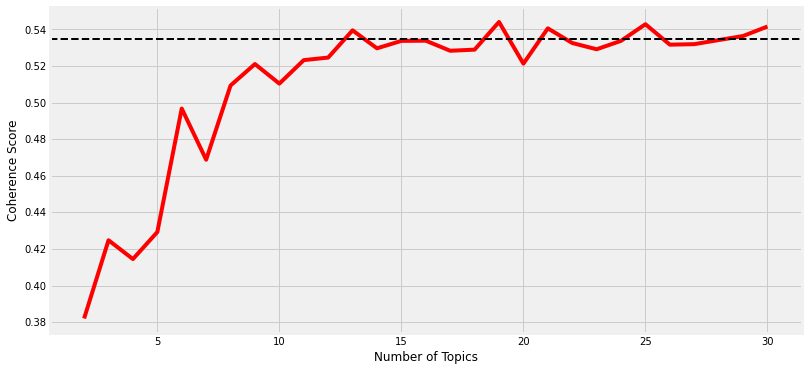

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, 31, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

На этом этапе необходимо интуитивно выбрать количество тем, которое является оптимальным по нашему мнению. Исходя из графика выберем количество тем, равное 25.

In [ ]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 25].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

25

Посмотрим на получившуюся тематическую модель LDA.

Для каждой из 25 тематик были подобраны связанные с ней слова и фразы.

In [ ]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic])  
                              for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)]
                         )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"class, classification, classifier, sample, probability, loss, pattern, machine, hypothesis, training, distribution, query, concept, decision, margin, instance, label, nearest_neighbor, target, perceptron"
Topic2,"vector, matrix, kernel, transformation, linear, distance, feature, representation, pca, dimensional, direction, component, principal_component, projection, dimension, support_vector, manifold, prototype, subspace, technique"
Topic3,"state, sequence, recurrent, dynamic, step, transition, attractor, continuous, context, mode, length, dynamical_system, discrete, automaton, matrix, trajectory, markov, hidden, initial, modeling"
Topic4,"training, prediction, test, training_set, trained, expert, table, average, task, selection, experiment, test_set, ensemble, size, bias, generalization, cross_validation, measure, accuracy, feature"
Topic5,"control, module, trajectory, position, motor, controller, movement, robot, dynamic, hand, forward, change, feedback, arm, task, behavior, force, field, environment, move"
Topic6,"state, action, policy, step, reinforcement_learning, task, environment, optimal, control, reward, goal, td, agent, trial, rl, reinforcement, current, machine, exploration, sutton"
Topic7,"application, processor, computer, user, parallel, rate, block, speed, program, technique, implementation, machine, architecture, processing, experiment, call, computation, type, board, size"
Topic8,"memory, pattern, code, bit, vector, capacity, neuron, hopfield, probability, connection, binary, stored, associative_memory, recall, element, random, size, matrix, coding, decoding"
Topic9,"signal, frequency, channel, filter, detection, sound, auditory, delay, temporal, phase, amplitude, spectral, event, processing, neural, window, spectrum, waveform, rate, eeg"
Topic10,"word, recognition, training, speech, character, feature, context, frame, letter, speaker, hmm, trained, digit, speech_recognition, phoneme, mlp, vowel, segmentation, hybrid, experiment"


**Интерпретация результата**

Имея набор данных и обученную LDA-модель, можно предсказать распределение тематик в каждом из документов (в нашем случае - в каждой из научно-исследовательских работ). Для каждой из тематик были подобраны различные фразы, соответствующие ей.


**Задания для самостоятельной работы:**

По аналогии с решенной задачей, построить модель набора тематик из заголовков журнала  "$Proceedings$ $of$ $the$ $National$ $Academy$ $of$ $Sciences$."

Замечания:

Для загрузки данных используйте команды

> !wget https://cs.nyu.edu/~roweis/data/pnas_all.mat

> !tar -xzf pnas_all.mat

Также не забудьте обработать данные формата .mat для работы в среде Python.